In [11]:
"""This is currently (16/10/19) just coppied from Raijin tile scale script with printing outputs
 added in below main script"""

'This is currently (16/10/19) just coppied from Raijin stile scale script with printing outputs\n added in below main script'

In [12]:
#Load modules
import datacube
import numpy as np
import xarray as xr
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import sys
import dask

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.virtual import construct_from_yaml

In [13]:
sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
#import BandIndices

dc = datacube.Datacube(app='tcw')

In [14]:
#define fuction to load Tasseled cap from yamal
def run_yaml_load(Thequery):
    prod = construct_from_yaml("""
    transform: expressions
    output:
        Wetness_Tasseled :
            formula: 0.0315 * blue + 0.2021 * green + 0.3102 * red + 0.1594 * nir + -0.6806 * swir1 + -0.6109 * swir2
            dtype: float32
            nodata: -999
    input:
        transform: apply_mask
        mask_measurement_name: pixelquality
        input:
            transform: make_mask
            flags:
                cloud_acca: no_cloud
                cloud_fmask: no_cloud
                cloud_shadow_acca: no_cloud_shadow
                cloud_shadow_fmask: no_cloud_shadow
                blue_saturated: False
                green_saturated: False
                red_saturated: False
                nir_saturated: False
                swir1_saturated: False
                swir2_saturated: False
                contiguous: True 
            mask_measurement_name: pixelquality
            input:
                juxtapose:
                    - product: ls8_nbart_albers
                    - product: ls8_pq_albers""")
    Data = prod.load(dc, **Thequery)
    want_to_mask = (Data== -999).to_array(dim='variables').all(dim='variables')
    terrain_out = Data.where(~want_to_mask, np.NaN)
    return terrain_out

In [15]:

#Define load data module Landsat PQ
def get_landsat_PQ(query):
    sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
    #print('PQ data',sensor_pq)
    return (sensor_pq)


# Define load data module Landsat 8
def get_landsat8(query):
    the_data = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
    #print(the_data)
    # turn terrain masked values form -999 to Nan

    want_to_mask = (the_data == -999).to_array(dim='variables').all(dim='variables')
    terrain_out = the_data.where(~want_to_mask, np.NaN)
    #print(terrain_out)
    return (terrain_out)


#Define load data module Wofs Summery
def get_wofs_summery(query):
    wofs_filtered_summary = dc.load(product='wofs_annual_summary', **query)

    return (wofs_filtered_summary)


#define do PQ removal
def mask_surface_reflectance(lst8_data,lst_PQ):
    # apply Mask
    # make Mask
    good_quality = masking.make_mask(lst_PQ.pixelquality,
                                     cloud_acca='no_cloud',
                                     cloud_fmask='no_cloud',
                                     cloud_shadow_acca='no_cloud_shadow',
                                     cloud_shadow_fmask='no_cloud_shadow',
                                     blue_saturated=False,
                                     green_saturated=False,
                                     red_saturated=False,
                                     nir_saturated=False,
                                     swir1_saturated=False,
                                     swir2_saturated=False,
                                     contiguous=True)

    Masked_lst8_data = lst8_data.where(good_quality)
    return(Masked_lst8_data)

def set_percent_threshold(Masked_lst8_data,X):
    total_obs = int(len(Masked_lst8_data.time))
    precent_threhold = total_obs * X
    return(precent_threhold)


def Find_wet_vegitation(Masked_lst8_data, wofs_summery,query):
    #do tassled cap

    TCW = run_yaml_load(query)
    #do Fisher
    lst_fisher = 1.7204 + (
                (171 * Masked_lst8_data['green']) + (3 * Masked_lst8_data['red']) - (70 * Masked_lst8_data['nir']) - (
                    45 * Masked_lst8_data['swir1']) - (71 * Masked_lst8_data['swir2'])) / 10000

    #find where both are true
    inundated_veg_msk = (np.logical_and(lst_fisher >= -10, TCW >= -400))
    inundated_veg = lst_fisher.where(inundated_veg_msk == True, 0)
    inundated_veg = inundated_veg.where(inundated_veg_msk == False, 1)

    #stack over time
    wet_veg_frequency = inundated_veg.sum(dim='time')

    #calculate percent threshold
    wet_min = set_percent_threshold(Masked_lst8_data,0.1)

    persistant_wet = wet_veg_frequency.where(wet_veg_frequency > wet_min, 0)
    #mask with wofs
    persistant_wet = persistant_wet.where(wofs_summery.frequency < 0.1, 0)
    return(persistant_wet)



#define Save
def _save(ds, name):
    write_geotiff(name, ds)

In [16]:
#run Main
#if __name__=='__main__':

output_file_path='/g/data/u46/users/ck9738/TasselledFisher/Tile_test_outputs/Carnegie_fulltile_2016.tiff'

query = {

    # Mathoura Large
#     'y': (-35.6545, -36.0320),
#     'x': (144.8179, 145.4289),

    
    #     #Daintree Rainforrest
#     'y': (-16.140, -16.209),
#     'x': (145.394, 145.460),
    
    #Cungulla
    'y': (-19.324, -19.531),
    'x': (147.057, 147.267),

     # Mathoura small
#     'y': (-35.782, -35.911),
#     'x': (144.887, 145.081),
    # lake dissapointment
    # 'y': (-23.2958, -23.410),
    # 'x': (123.0695, 123.230),
    # lake Carnegie
    # 'y': (-26.0, -26.5),
    # 'x': (122.5, 123.00),
    # lake Carnegie full
#     'y': (-25.5, -26.5),
#     'x': (122.0, 123.00),
    # random quater
    # 'y': (-35.5, -36.0),
    # 'x': (149.7, 150.2),
    # Pambula
    # 'y': (-36.900, -36.988),
    # 'x': (149.800, 149.925),


    'time': ('2016-01-01', '2016-12-31'),
    'crs': 'EPSG:4326',
    'output_crs': 'EPSG: 3577',
    'resolution': (-25, 25),

    'dask_chunks': {'x': 500, 'y': 500}
}
dask.config.set(get=dask.get)

#for area in areas:
    #output_file = output_file_path+''

data_SR = get_landsat8(query)
PQ_data = get_landsat_PQ(query)
wofs_summ = get_wofs_summery(query)

clear_data = mask_surface_reflectance(data_SR,PQ_data)



Wet_vegitation = Find_wet_vegitation(clear_data,wofs_summ,query)
# print(clear_data)

Data_out = clear_data.isel(time=0)
# print(Data_out )
Data_out['inundated_veg'] = Wet_vegitation.Wetness_Tasseled.astype('float64').isel(time=0)
Data_out['Wofs_frequency'] = wofs_summ.frequency.astype('float64').isel(time=0)
Data_out = Data_out.drop(['coastal_aerosol','blue','green','red','nir','swir1','swir2'])
Data_out = Data_out.compute(scheduler='single-threaded')
print(Data_out)

'''Other compute Optioins for Dask Array:

x.compute(scheduler='single-threaded')
x.compute(scheduler='threads')
x.compute(scheduler='processes')
'''

#    _save(Data_out,output_file_path)

/g/data/v10/public/modules/dea-env/20190902/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater_equal
  return func(*args2)


<xarray.Dataset>
Dimensions:         (x: 983, y: 1018)
Coordinates:
    time            datetime64[ns] 2016-01-02T00:10:43
  * y               (y) float64 -2.162e+06 -2.162e+06 ... -2.187e+06 -2.187e+06
  * x               (x) float64 1.571e+06 1.571e+06 ... 1.595e+06 1.596e+06
Data variables:
    inundated_veg   (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Wofs_frequency  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    crs:      EPSG: 3577


"Other compute Optioins for Dask Array:\n\nx.compute(scheduler='single-threaded')\nx.compute(scheduler='threads')\nx.compute(scheduler='processes')\n"

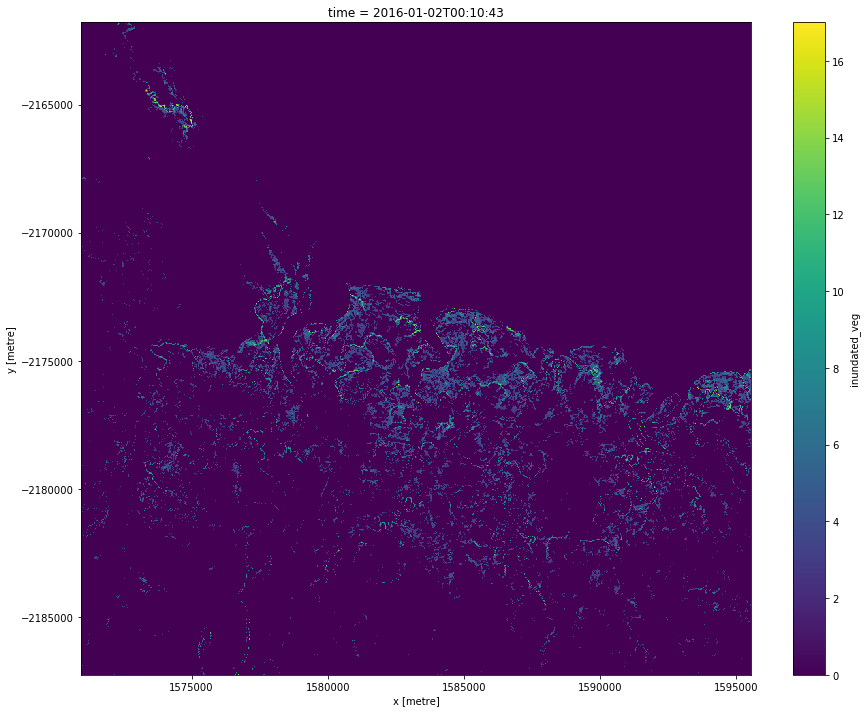

In [24]:
Data_out.inundated_veg.plot(cmap='viridis',figsize =(15,12))

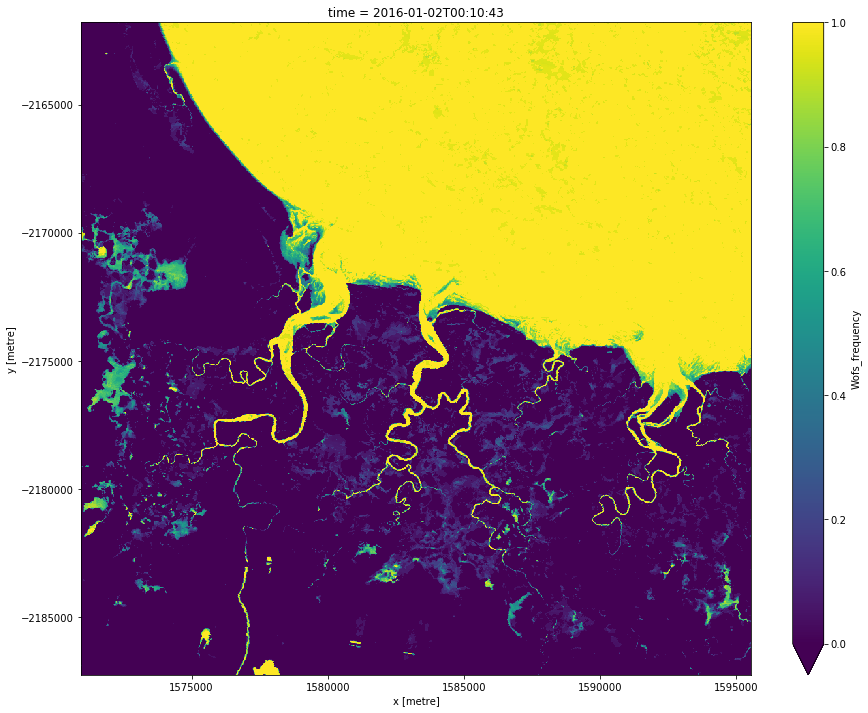

In [18]:
Data_out.Wofs_frequency.plot(cmap='viridis',figsize =(15,12), vmin=0)

In [19]:
#_save(Data_out,output_file_path)

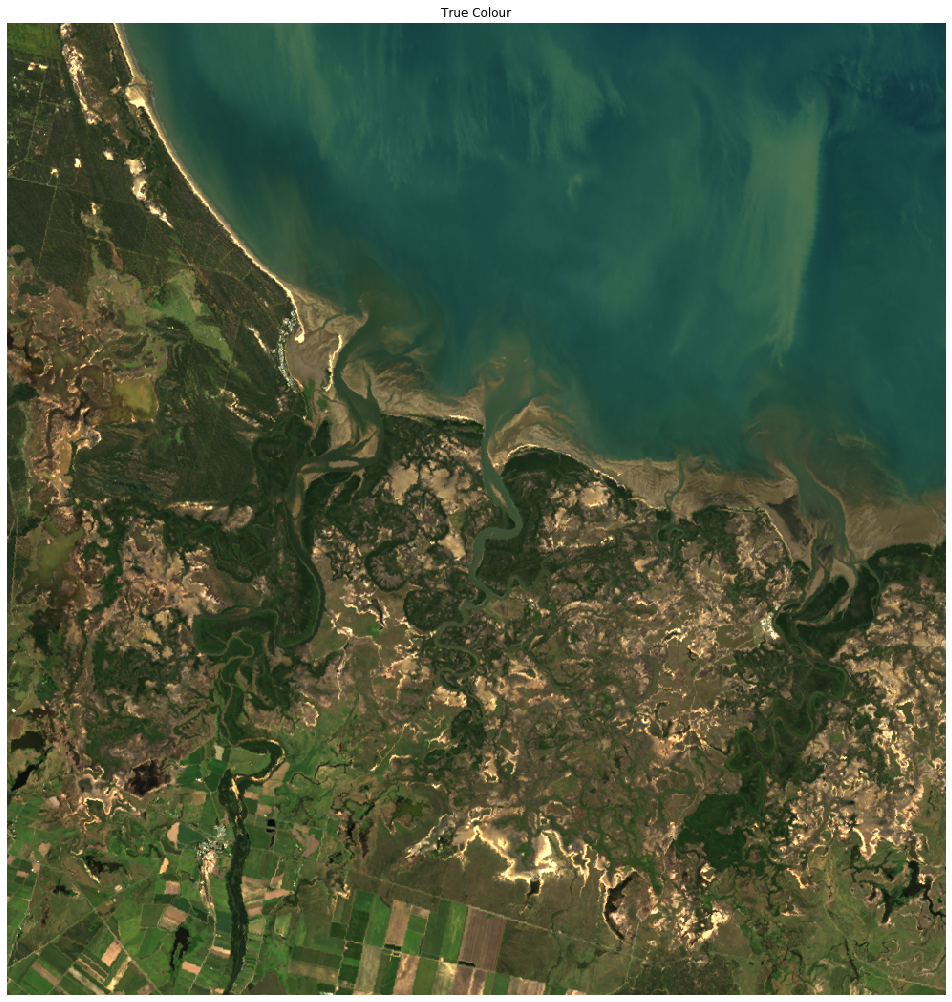

In [20]:
data_lst8_once = clear_data.isel(time=13).compute(scheduler='single-threaded')

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 2000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image